[*********************100%%**********************]  1 of 1 completed


Fitting 5 folds for each of 972 candidates, totalling 4860 fits
[CV] END colsample_bytree=0.8, gamma=0.0, max_depth=3, min_child_weight=1, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0.0, max_depth=3, min_child_weight=1, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.0, max_depth=3, min_child_weight=1, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.0, max_depth=3, min_child_weight=1, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.0, max_depth=3, min_child_weight=1, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.0, max_depth=3, min_child_weight=1, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.0, max_depth=3, min_child_weight=1, reg_alpha=0.0, reg_la

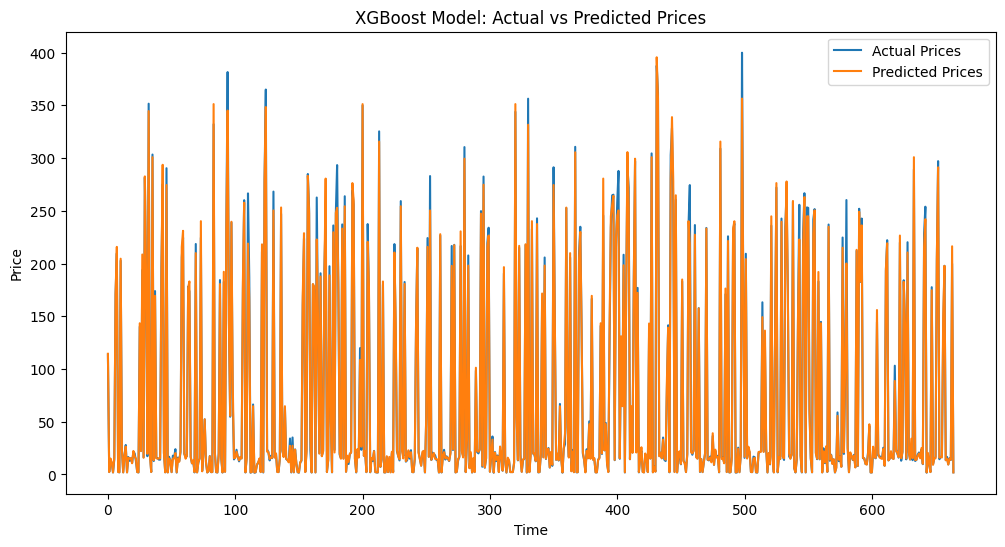

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

# Fetch data from Yahoo Finance
start = '2010-01-01'
end = '2024-06-30'
ticker_symbol = 'TSLA'
df = yf.download(ticker_symbol, start=start, end=end)

# Drop unnecessary columns and reset index
df = df[['Close']].reset_index(drop=True)

# Create moving averages
df['MA100'] = df['Close'].rolling(window=100).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

# Drop rows with NaN values due to rolling averages
df.dropna(inplace=True)

# Define features and target for XGBoost
X = df[['MA100', 'MA200']]  # Features: Moving averages as predictors
y = df['Close']  # Target: Closing prices

# Split data into training and testing sets for XGBoost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data for XGBoost
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)

# Define parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0.0, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.0, 0.1, 0.5]
}

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Use best model from GridSearchCV
best_xgb_model = grid_search.best_estimator_

# Train best model
best_xgb_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_train = best_xgb_model.predict(X_train_scaled)
y_pred_test = best_xgb_model.predict(X_test_scaled)

# Calculate RMSE for testing set
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)

# Calculate Average Actual Price
avg_actual_price = np.mean(y_test)

# Calculate Percentage Accuracy
percentage_accuracy = 100 * (1 - (rmse_test / avg_actual_price))

print(f'Mean Squared Error (Test): {mse_test}')
print(f'Root Mean Squared Error (Test): {rmse_test}')
print(f'Average Actual Price: {avg_actual_price}')
print(f'Percentage Accuracy: {percentage_accuracy:.2f}%')

# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Prices')
plt.plot(y_pred_test, label='Predicted Prices')
plt.title('XGBoost Model: Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
